# Simple SSB implementation

This example contains a simplified implementation of the incremental SSB for re-implementation in other languages and for modifications.

* Process whole frames, no slicing
* No MaskContainer for the same reason
* No CUDA
* Only subpix method for mask generation

LiberTEM is still used to simplify decoding the input file. See https://libertem.github.io/LiberTEM/udf.html#how-udfs-works for a pseudo code equivalent of LiberTEM UDFs in case you'd like to implement this algorithm in a simple loop without LiberTEM.

In [1]:
import math

import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt

import sparse

In [2]:
from libertem import api
from libertem.executor.inline import InlineJobExecutor
from libertem.udf.base import UDF
from libertem.masks import circular
from libertem.corrections.coordinates import flip_y, rotate_deg, identity

In [3]:
# Calculation of the relativistic electron wavelength in meters
def wavelength(U):
    e = const.elementary_charge  # Elementary charge  !!! 1.602176634×10−19
    h = const.Planck  # Planck constant    !!! 6.62607004 × 10-34
    c = const.speed_of_light  # Speed of light
    m_0 = const.electron_mass  # Electron rest mass

    T = e*U*1000
    lambda_e = h*c/(math.sqrt(T**2+2*T*m_0*(c**2)))
    return lambda_e

In [4]:
def empty_mask(mask_shape, dtype):
    '''
    Return an empty sparse mask

    Improve readability
    '''
    return sparse.zeros(mask_shape, dtype=dtype)


def mask_pair_subpix(cy, cx, sy, sx, filter_center, semiconv_pix):
    '''
    Calculate positive and negative trotter mask for circular illumination
    using a method with subpixel capability.

    Parameters
    ----------

    cy, cx : float
        Position of the optical axis on the detector in px, center of illumination
    sy, sx : float
        Trotter shift value in px
    filter_center : numpy.ndarray
        Center illumination, i.e. zero order disk. This has to be circular and match the radius
        semiconv_pix. It is just passed as an argument for efficientcy to avoid unnecessary
        recalculation.
    semiconv_pix : float
        Semiconvergence angle in measured in detector pixel, i.e. radius of the zero order disk.

    Returns
    -------

    mask_positive, mask_negative : numpy.ndarray
        Positive and negative trotter mask
    '''
    mask_shape = filter_center.shape

    filter_positive = circular(
        centerX=cx+sx, centerY=cy+sy,
        imageSizeX=mask_shape[1], imageSizeY=mask_shape[0],
        radius=semiconv_pix,
        antialiased=True
    )

    filter_negative = circular(
        centerX=cx-sx, centerY=cy-sy,
        imageSizeX=mask_shape[1], imageSizeY=mask_shape[0],
        radius=semiconv_pix,
        antialiased=True
    )
    mask_positive = filter_center * filter_positive * (filter_negative == 0)
    mask_negative = filter_center * filter_negative * (filter_positive == 0)
    return mask_positive, mask_negative



def generate_mask(cy, cx, sy, sx, filter_center, semiconv_pix,
                  cutoff, dtype):
    '''
    Generate the trotter mask for a specific shift sy, sx

    Parameters
    ----------

    cy, cx : float
        Position of the optical axis on the detector in px, center of illumination
    sy, sx : float
        Trotter shift value in px
    filter_center : numpy.ndarray
        Center illumination, i.e. zero order disk. This has to be circular and match the radius
        semiconv_pix if :code:`method=subpix`. It is passed for re-use to avoid unnecessary
        recalculation
    semiconv_pix : float
        Semiconvergence angle in measured in detector pixel, i.e. radius of the zero order disk.
    cutoff : int
        Minimum number of pixels in the positive and negative trotter. This can be used to purge
        very small trotters to reduce noise.
    dtype : numpy dtype
        dtype to use for the mask

    Returns
    -------
    mask : sparse.COO
        Mask in sparse.pydata.org COO format

    '''
    mask_shape = filter_center.shape
    # 1st diffraction order and primary beam don't overlap
    if sx**2 + sy**2 > 4*np.sum(semiconv_pix**2):
        return empty_mask(mask_shape, dtype=dtype)

    if np.allclose((sy, sx), (0, 0)):
        # The zero order component (0, 0) is special, comes out zero with above code
        m_0 = filter_center / filter_center.sum()
        return sparse.COO(m_0.astype(dtype))

    params = dict(
        cy=cy, cx=cx, sy=sy, sx=sx,
        filter_center=filter_center,
        semiconv_pix=semiconv_pix,
    )

    mask_positive, mask_negative = mask_pair_subpix(**params)

    non_zero_positive = mask_positive.sum()
    non_zero_negative = mask_negative.sum()

    if non_zero_positive >= cutoff and non_zero_negative >= cutoff:
        m = (
            mask_positive / non_zero_positive
            - mask_negative / non_zero_negative
        ) / 2
        return sparse.COO(m.astype(dtype))
    else:
        # Exclude small, missing or unbalanced trotters
        return empty_mask(mask_shape, dtype=dtype)


def generate_masks(reconstruct_shape, mask_shape, dtype, lamb, dpix, semiconv,
        semiconv_pix, transformation=None, cy=None, cx=None, cutoff=1,
        cutoff_freq=np.float32('inf')):
    '''
    Generate the trotter mask stack.

    The y dimension is trimmed to size(y)//2 + 1 to exploit the inherent
    symmetry of the mask stack.

    Parameters
    ----------

    reconstruct_shape : tuple(int)
        Shape of the reconstructed area
    mask_shape : tuple(int)
        Shape of the detector
    dtype : numpy dtype
        dtype to use for the mask stack
    lamb : float
        Wavelength of the illuminating radiation in m
    dpix : float or (float, float)
        Scan step in m. Tuple (y, x) in case scan step is different in x and y direction.
    semiconv : float
        Semiconvergence angle of the illumination in radians
    semiconv_pix : float
        Semiconvergence angle in measured in detector pixel, i.e. radius of the zero order disk.
    transformation : numpy.ndarray, optional
        Matrix for affine transformation from the scan coordinate directions
        to the detector coordinate directions. This does not include the scale, which is handled by
        dpix, lamb, semiconv and semiconv_pix. It should only be used to rotate and flip
        the coordinate system as necessary. See also
        https://github.com/LiberTEM/LiberTEM/blob/master/src/libertem/corrections/coordinates.py
    cy, cx : float, optional
        Position of the optical axis on the detector in px, center of illumination.
        Default: Center of the detector
    cutoff : int, optional
        Minimum number of pixels in the positive and negative trotter. This can be used to purge
        very small trotters to reduce noise. Default is 1, i.e. no cutoff unless one trotter is
        empty.
    cutoff_freq: float
        Trotters belonging to a spatial frequency higher than this value in reciprocal pixel
        coordinates will be cut off.

    Returns
    -------
    masks : sparse.COO
        Masks in sparse.pydata.org COO format. y and x frequency index are FFT shifted, i.e. the
        zero frequency is at (0,0) and negative frequencies are in the far quadrant and reversed.
        The y frequency index is cut in half with size(y)//2 + 1 to exploit the inherent symmetry
        of a real-valued Fourier transform. The y and x index are then flattened to make it
        suitable for using it with MaskContainer.
    '''
    reconstruct_shape = np.array(reconstruct_shape)

    dpix = np.array(dpix)

    d_Kf = np.sin(semiconv)/lamb/semiconv_pix
    d_Qp = 1/dpix/reconstruct_shape

    if cy is None:
        cy = mask_shape[0] / 2
    if cx is None:
        cx = mask_shape[1] / 2

    if transformation is None:
        transformation = identity()

    filter_center = circular(
        centerX=cx, centerY=cy,
        imageSizeX=mask_shape[1], imageSizeY=mask_shape[0],
        radius=semiconv_pix,
        antialiased=True
    )

    half_reconstruct = (reconstruct_shape[0]//2 + 1, reconstruct_shape[1])
    masks = []

    for row in range(half_reconstruct[0]):
        for column in range(half_reconstruct[1]):
            # Do an fftshift of q and p
            qp = np.array((row, column))
            flip = qp > (reconstruct_shape / 2)
            real_qp = qp.copy()
            real_qp[flip] = qp[flip] - reconstruct_shape[flip]

            if np.sum(real_qp**2) > cutoff_freq**2:
                masks.append(empty_mask(mask_shape, dtype=dtype))
                continue

            # Shift of diffraction order relative to zero order
            # without rotation in physical coordinates
            real_sy_phys, real_sx_phys = real_qp * d_Qp
            # We apply the transformation backwards to go
            # from physical orientation to detector orientation,
            # while the forward direction in center of mass analysis
            # goes from detector coordinates to physical coordinates
            # Afterwards, we transform from physical detector coordinates
            # to pixel coordinates
            sy, sx = ((real_sy_phys, real_sx_phys) @ transformation) / d_Kf

            masks.append(generate_mask(
                cy=cy, cx=cx, sy=sy, sx=sx,
                filter_center=filter_center,
                semiconv_pix=semiconv_pix,
                cutoff=cutoff,
                dtype=dtype,
            ))

    # Since we go through masks in order, this gives a mask stack with
    # flattened (q, p) dimension to work with dot product and mask container
    masks = sparse.stack(masks)
    return masks


In [5]:
class SimpleSSB(UDF):
    def __init__(self, converted_masks, dtype):
        '''
        Parameters
        ----------
        
        converted_masks : scipy.sparse.csc
            Mask stack with flattened sig and transposed.
        
        dtype : dtype
            dtype to use for computation
        '''
        super().__init__(converted_masks=converted_masks, dtype=dtype)

    def get_result_buffers(self):
        dtype = np.result_type(np.complex64, self.params.dtype)
        return {
            'pixels': self.buffer(
                kind="single", dtype=dtype, extra_shape=self.reconstruct_shape,
                where='device'
            ),
        }

    def get_task_data(self):
        ds_nav = tuple(self.meta.dataset_shape.nav)

        # Precalculate values for Fourier transform
        # The y axis is trimmed in half since the full trotter stack is symmetric,
        # i.e. the missing half can be reconstructed from the other results
        row_steps = -2j*np.pi*np.linspace(0, 1, self.reconstruct_shape[0], endpoint=False)
        col_steps = -2j*np.pi*np.linspace(0, 1, self.reconstruct_shape[1], endpoint=False)

        half_y = self.reconstruct_shape[0] // 2 + 1
        full_x = self.reconstruct_shape[1]

        # Precalculated LUT for Fourier transform
        row_exp = np.exp(
            row_steps[:, np.newaxis]
            * np.arange(half_y)[np.newaxis, :]
        )
        col_exp = np.exp(
            col_steps[:, np.newaxis]
            * np.arange(full_x)[np.newaxis, :]
        )
        steps_dtype = np.complex128

        return {
            "row_exp": row_exp.astype(steps_dtype),
            "col_exp": col_exp.astype(steps_dtype),
        }
    
    @property
    def reconstruct_shape(self):
        return tuple(self.meta.dataset_shape.nav)


    def merge(self, dest, src):
        dest['pixels'][:] = dest['pixels'] + src['pixels']
        
    def process_frame(self, frame):
        dot_result = frame.reshape((-1, )) @ self.params.converted_masks
        self.merge_dot_result(dot_result)
        
    def merge_dot_result(self, dot_result):
        half_y = self.results.pixels.shape[0] // 2 + 1
        
        # Get the real x and y indices within the dataset navigation dimension
        # for the current tile
        y_indices = self.meta.coordinates[:, 0]
        x_indices = self.meta.coordinates[:, 1]

        factors_dtype = np.result_type(np.complex64, self.params.dtype)

        fourier_factors_row = self.task_data.row_exp[y_indices, :half_y, np.newaxis]
        fourier_factors_col = self.task_data.col_exp[x_indices, np.newaxis, :]
        
        # Fold up the flat result to match the row and column Fourier factors
        dot_result = dot_result.reshape((1, half_y, self.results.pixels.shape[1]))

        self.results.pixels[:half_y] += np.einsum(
            'i...,i...,i...',
            dot_result,
            fourier_factors_row,
            fourier_factors_col
        )    
        
    def postprocess(self):
        '''
        Patch in the missing half of the result buffer that we saved ourselves to calculate
        '''
        half_y = self.results.pixels.shape[0] // 2 + 1
        # patch accounts for even and odd sizes
        # FIXME make sure this is correct using an example that transmits also
        # the high spatial frequencies
        patch = self.results.pixels.shape[0] % 2
        # We skip the first row since it would be outside the FOV
        extracted = self.results.pixels[1:self.results.pixels.shape[0] // 2 + patch]
        # The coordinates of the bottom half are inverted and
        # the zero column is rolled around to the front
        # The real part is inverted
        self.results.pixels[half_y:] = -np.conj(
            np.roll(np.flip(extracted, axis=(0, 1)), shift=1, axis=1)
        )

In [6]:
# The notebook currently ONLY works well with inline job executor
# since the mask stack is pre-calculated externally
executor = InlineJobExecutor()
ctx = api.Context(executor=executor)

In [7]:
ds_shape_sig = (256, 256)
ds_shape_nav = (128, 128)
# ds_shape_nav = (256, 256)
# Acceleration voltage in keV
U = 300
# U = 200
params = {
    "dpix": 12.7e-12,
    "cy": 126,
    "cx": 123,
    "semiconv": 22.1346e-3,
    "semiconv_pix": 31,
    "dtype": np.float64,
    # applied right to left
    "transformation": rotate_deg(88) @ flip_y(),
    "cutoff": 15,
}

In [8]:
ds = ctx.load("MIB", path=r'/storage/holo/clausen/testdata/ER-C-1/projects/ptycho-4.0/data/live-ssb-paper/Ptycho01/20200518 165148/default.hdr')

In [9]:
masks = generate_masks(
    **params,
    mask_shape=ds_shape_sig,
    lamb=wavelength(U),
    reconstruct_shape=ds_shape_nav,
)

In [10]:
# Flatten sig and transpose for CSC dot product
converted_masks = masks.reshape((-1, np.prod(ds.shape.sig))).T.tocsc()

In [11]:
udf = SimpleSSB(converted_masks=converted_masks, dtype=np.complex128)

In [12]:
%%time
result = ctx.run_udf(udf=udf, dataset=ds)

/Users/weber/.conda/envs/ptycho37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UseDiscouragedWarning: dict-like access is discouraged, as it can be confusing vs. using attribute access


CPU times: user 1min 9s, sys: 2.68 s, total: 1min 12s
Wall time: 1min 4s


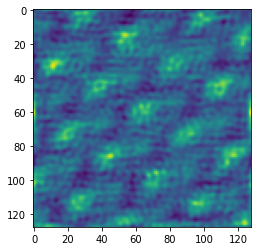

In [13]:
fig, axes = plt.subplots()
axes.imshow(np.angle(np.fft.ifft2(result["pixels"].data)))